In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import urllib.request
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import string
from hanspell import spell_checker
from tqdm.notebook import tqdm
from soynlp.normalizer import *
import MeCab
from konlpy.tag import *
import json
import re
from sklearn.model_selection import train_test_split

class Mecab:
    def pos(self, text):
        p = re.compile(".+\t[A-Z]+")
        return [tuple(p.match(line).group().split("\t")) for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
    
    def morphs(self, text):
        p = re.compile(".+\t[A-Z]+")
        return [p.match(line).group().split("\t")[0] for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
    
    def nouns(self, text):
        p = re.compile(".+\t[A-Z]+")
        temp = [tuple(p.match(line).group().split("\t")) for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
        nouns=[]
        for word in temp:
            if word[1] in ["NNG", "NNP", "NNB", "NNBC", "NP", "NR"]:
                nouns.append(word[0])
        return nouns
    
mcb = Mecab()

tqdm.pandas()

plt.style.use("dark_background")

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.3\lib\site-packages\tqdm\std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x28eef038108>)

In [ ]:
data = pd.read_table("steam.txt", names=["label", "review"])

In [ ]:
data["review"] = data["review"].str.replace(f"[{string.punctuation}]", " ")
data["review"] = data["review"].str.replace(r" +", " ")
data = data[data["review"]!=" "]
data = data.dropna(axis=0)
data = data.drop_duplicates(["review"], keep="first")

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


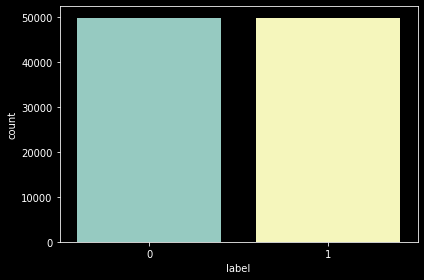

In [ ]:
fig, ax = plt.subplots()

sb.countplot(data["label"])

fig.tight_layout()

In [ ]:
data["morphs"] = data["review"].progress_apply(mcb.morphs)
# data["pos"] = data["review"].progress_apply(mcb.pos)

In [ ]:
train, test = train_test_split(data, train_size=0.8, shuffle=True, random_state=231)

train_X = train["morphs"].tolist()
train_y = np.array(train["label"])

test_X = test["morphs"].tolist()
test_y = np.array(test["label"])

tkn = tf.keras.preprocessing.text.Tokenizer()
tkn.fit_on_texts(train_X)
word2idx = tkn.word_index
word2cnts = dict(sorted(tkn.word_counts.items(), key=lambda x:x[1], reverse=True))

cnts = list(word2cnts.values())
ratio = 0.99
for vocab_size, value in enumerate(np.cumsum(cnts)/np.sum(cnts)):
    if value >= ratio:
        break

print(f"{vocab_size:,}개의 단어로 전체 data의 {ratio:.0%}를 표현할 수 있습니다.")
print(f"{len(word2idx):,}개의 단어 중 {vocab_size/len(word2idx):.1%}에 해당합니다.")


20,753개의 단어로 전체 data의 99%를 표현할 수 있습니다.
37,753개의 단어 중 55.0%에 해당합니다.


In [ ]:
tkn = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size+2, oov_token="OOV")
tkn.fit_on_texts(train_X)
word2idx = tkn.word_index
word2cnts = dict(sorted(tkn.word_counts.items(), key=lambda x:x[1], reverse=True))

train_X = tkn.texts_to_sequences(train_X)
test_X = tkn.texts_to_sequences(test_X)

lens = sorted([len(doc) for doc in train_X])
for idx, max_len in enumerate(lens):
    if idx/len(lens) >= ratio:
        break
print(f"길이가 {max_len} 이하인 리뷰가 전체의 {ratio:.0%}를 차지합니다.")

길이가 65 이하인 리뷰가 전체의 99%를 차지합니다.


In [ ]:
train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, maxlen=max_len)
test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, maxlen=max_len)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=vocab_size+2, output_dim=64))
hidden_size = 128
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hidden_size)))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=2)
model_path = "steam_review_bidirectional_lstm.h5"
mc = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor="val_binary_accuracy", mode="auto", verbose=1, save_best_only=True)

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["binary_accuracy"])

batch_size = 256
hist = model.fit(x=train_X, y=train_y, validation_split=0.2, batch_size=batch_size, epochs=10, verbose=1, callbacks=[es, mc])

Epoch 1/10


KeyboardInterrupt: 

In [ ]:
model = tf.keras.models.load_model(model_path)

model.evaluate(x=test_X, y=test_y, batch_size=batch_size, verbose=1)

78/78 [==============================] - 17s 220ms/step - loss: 0.4575 - binary_accuracy: 0.7931


[0.4575434923171997, 0.7930930852890015]

In [ ]:
def sentiment_predict(sent):
    sent = mcb.morphs(sent)
    seq = tkn.texts_to_sequences([sent])
    pad = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_len)
    score = float(model.predict(pad))
    print(f"이 문장의 긍정도는 {score:.1%}입니다.")

In [ ]:
sentiment_predict("노잼 ..완전 재미 없음 ㅉㅉ")

이 문장의 긍정도는 3.4%입니다.


In [ ]:
sentiment_predict("조금 어렵지만 재밌음ㅋㅋ")

이 문장의 긍정도는 98.7%입니다.


In [ ]:
sentiment_predict("케릭터가 예뻐고 재밌기도 합니다만 애매하네요")

이 문장의 긍정도는 34.1%입니다.
